In [14]:
import collections
from datetime import datetime
import itertools
import logging
import multiprocessing
import os
import random

import keras
from keras import layers, models, optimizers
from keras.applications import VGG16
from lightgbm import LGBMClassifier, LGBMRegressor
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import f_oneway, ttest_ind
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso, LogisticRegression, RidgeClassifier, Ridge
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
import tensorflow as tf
from xgboost import XGBClassifier


tf.get_logger().setLevel(logging.ERROR)

# Problem 

The problem is described in detail [here](https://www.aicrowd.com/challenges/ai-blitz-4/problems/crdio).  Given attributes of a fetal heart monitor, predict the health state of the fetus (N: Normal, S:Suspect, or P: Pathological)

Attribute Information:

1. LBE: FHR baseline value (medical expert) (beats per minute)
2. LB: FHR baseline (SisPorto) (beats per minute)
3. AC: Number of accelerations per second
4. FM: Number of fetal movements per second
5. UC: Number of uterine contractions per second
6. ASTV: percentage of time with abnormal short term variability
7. MSTV: mean value of short term variability
8. ALTV: percentage of time with abnormal long term variability
9. MLTV: mean value of long term variability
10. DL: Number of light decelerations per second
11. DS: Number of severe decelerations per second
12. DP: Number of prolonged decelerations per second
13. DR: Number of repetitive decelerations per second
14. Width: width of FHR histogram
15. Min: minimum of FHR histogram
16. Max: maximum of FHR histogram
17. Nmax: Number of histogram peaks
18. Nzeros: Number of histogram zeros
19. Mode: histogram mode
20. Mean: histogram mean
21. Median: histogram median
22. Variance: histogram variance
23. Tendency: histogram tendency
24. NSP: Normal=1; Suspect=2; Pathologic=3

The attributes are provided as a CSV file (as tabular data) with a column (NSP) corresponding to the target labels. The target labels can take one of three values: Normal=1; Suspect=2; Pathologic=3.  The attributes (input features) are a combination of continuous and categorical variables.  This can be modelled as a regression or a classification problem, however regression is a better choice since there is inherent order in the target labels even though they are discrete. 
 

# General Approach

**Step 1 - Data Preprocessing:**
* Investigate the correlation coefficients between features to remove highly collinear features.  Remove non-informative features (such as DR) 
* Adjust the labels (from 1, 2, and 3) to 0, 1, and 2 for processing by various classifiers. 

**Step 2 - Exploratory Analysis:**
* Investigate the correlation matrix and pairplot for any remaining collinearity.  
* Identify continuous and categorical variables. 
* Determine if the labels are balanced and, if not, the extent of imbalance for use of class weights. 

**Step 3 - Tests for statistical significance:**
* For each variable, perform an independent two-samples t-test to examine if there are statistical differences between normal and suspect groups and between normal and pathological groups.  Adjust the results for multiple comparisons using the Holm-Bonferroni method (or the simple Bonferroni method).  See [here](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method).  Assuming the variances of groups to be unequal, the null hypothesis for the t-tests is that the two samples being compared (normal and suspect or normal and pathological, for each feature, in this case) have the same mean.  A p-value less than the significance level (assume 0.001 here) adjusted by Holm-Bonferroni method indicates that the null hypothesis can be rejected.  Using this approach, statistically significant differences were obtained (at the 0.001 significance level) between normal and suspect as well as normal and pathological groups for the following features: AC, ASTV, ALTV, DL, Median, Variance
* For each variable, perform one-way ANOVA test to compare multiple group pairs to test the null hypothesis that two or more groups have the same mean.  

**Step 4A - Perform Regression:**
* Test the relative performance of multiple regressors using the mean of five-fold cross-validation accuracy
* Classifiers used here were: Ridge, Random Forest, and Boosted Trees (LightGBM).
* The Boosted Trees gave the best cross-validated accuracy of ~95%

**Step 4B - Perform Classification:**
* Test the relative performance of multiple classifiers using the mean of five-fold cross-validation accuracy
* Classifiers used here were: Logistic Regression, Lasso, Ridge, Linear Discriminant Analysis (LDA), Random Forest, Boosted Trees (LightGBM and XGBoost), and Dense Neural Networks
* The Boosted Trees gave the best cross-validated accuracy of ~95%

**Step 5 - Inference:**
* Generate a submission file for the test dataset

In [2]:
df = pd.read_csv('train.csv')
df.head()

LBE     LB    AC   FM   UC  ASTV  MSTV  ALTV  MLTV   DL  ...    Min  \
0  135.0  135.0   8.0  2.0  7.0  60.0   1.0   0.0   5.2  0.0  ...  123.0   
1  133.0  133.0   0.0  4.0  6.0  60.0   2.5   0.0   0.0  4.0  ...   83.0   
2  135.0  135.0  10.0  2.0  4.0  60.0   0.9   0.0   0.5  0.0  ...  124.0   
3  120.0  120.0   3.0  1.0  2.0  56.0   0.5   0.0   8.8  0.0  ...  106.0   
4  132.0  132.0   6.0  0.0  6.0  27.0   1.7   0.0  11.3  0.0  ...   54.0   

     Max  Nmax  Nzeros   Mode   Mean  Median  Variance  Tendency  NSP  
0  163.0   0.0     0.0  148.0  142.0   145.0       7.0       0.0    1  
1  148.0   2.0     0.0  131.0  122.0   130.0      14.0       1.0    1  
2  163.0   1.0     0.0  148.0  143.0   146.0       6.0       0.0    1  
3  141.0   1.0     0.0  125.0  125.0   126.0       3.0       0.0    1  
4  176.0   8.0     0.0  150.0  146.0   149.0      18.0       1.0    1  

[5 rows x 24 columns]

#### Investigate correlation matrix for collinearities

<AxesSubplot:>

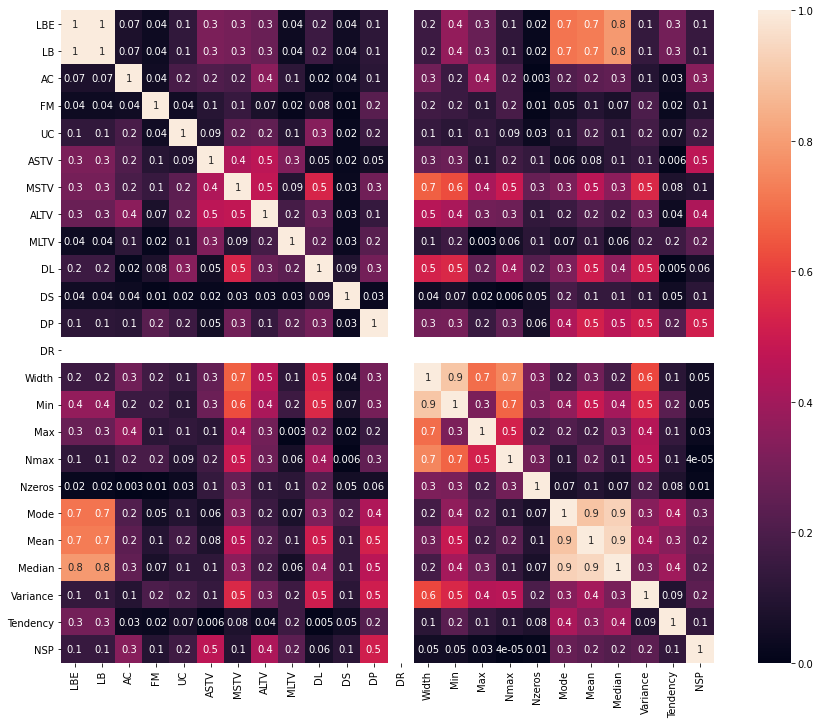

In [3]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(df.corr().abs(), vmin=0, vmax=1, annot=True, fmt='0.1g', square=True, ax=ax)

#### Remove highly collinear features, based on the above correlation matrix

In [3]:
df.drop(['DR', 'DS', 'LBE', 'Mode', 'Mean'], axis=1, inplace=True)

In [11]:
df.dtypes

LB          float64
AC          float64
FM          float64
UC          float64
ASTV        float64
MSTV        float64
ALTV        float64
MLTV        float64
DL          float64
DP          float64
Width       float64
Min         float64
Max         float64
Nmax        float64
Nzeros      float64
Median      float64
Variance    float64
Tendency    float64
NSP           int64
dtype: object

In [4]:
X_df = df.iloc[:, :-1]
X_df = (X_df - X_df.mean()) / X_df.std()
X_df.head()

LB        AC        FM        UC      ASTV      MSTV      ALTV  \
0  0.180845  1.539655 -0.138993  1.220255  0.765690 -0.380371 -0.531412   
1 -0.022285 -0.777409 -0.081690  0.861667  0.765690  1.327282 -0.531412   
2  0.180845  2.118921 -0.138993  0.144490  0.765690 -0.494215 -0.531412   
3 -1.342627  0.091490 -0.167644 -0.572687  0.532645 -0.949589 -0.531412   
4 -0.123849  0.960389 -0.196295  0.861667 -1.156932  0.416533 -0.531412   

       MLTV        DL        DP     Width       Min       Max      Nmax  \
0 -0.527742 -0.628621 -0.276609 -0.772622  0.987466 -0.053205 -1.377417   
1 -1.440259  1.017365 -0.276609 -0.135331 -0.358044 -0.890683 -0.706373   
2 -1.352517 -0.628621 -0.276609 -0.798113  1.021104 -0.053205 -1.041895   
3  0.104000 -0.628621 -0.276609 -0.900080  0.415624 -1.281506 -1.041895   
4  0.542710 -0.628621 -0.276609  1.317693 -1.333539  0.672610  1.306760   

    Nzeros    Median  Variance  Tendency  
0 -0.45297  0.485987 -0.399269 -0.514108  
1 -0.45297 -0.545961 -0.163168  1.125637  
2 -0.45297  0.554783 -0.432997 -0.514108  
3 -0.45297 -0.821147 -0.534183 -0.514108  
4 -0.45297  0.761173 -0.028253  1.125637

In [5]:
y = df['NSP'] - 1

# Exploratory analysis

<AxesSubplot:>

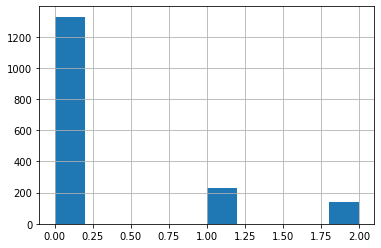

In [9]:
y.hist()

In [10]:
df.corr()

LB        AC        FM        UC      ASTV      MSTV  \
LB        1.000000 -0.074488 -0.035304 -0.129210  0.312743 -0.299340   
AC       -0.074488  1.000000  0.043788  0.188684 -0.209886  0.194833   
FM       -0.035304  0.043788  1.000000 -0.043805 -0.103194  0.146930   
UC       -0.129210  0.188684 -0.043805  1.000000 -0.086439  0.240630   
ASTV      0.312743 -0.209886 -0.103194 -0.086439  1.000000 -0.433417   
MSTV     -0.299340  0.194833  0.146930  0.240630 -0.433417  1.000000   
ALTV      0.270388 -0.350721 -0.070543 -0.248241  0.464760 -0.474363   
MLTV     -0.038108 -0.120497  0.018852 -0.100885 -0.321455  0.094281   
DL       -0.160060 -0.022493  0.077370  0.337450 -0.048997  0.533809   
DP       -0.117746 -0.111798  0.229721  0.158391  0.054136  0.288307   
Width    -0.156991  0.288297  0.171292  0.143289 -0.259598  0.665490   
Min       0.368025 -0.154758 -0.155595 -0.109814  0.275401 -0.627579   
Max       0.267005  0.374561  0.116909  0.131563 -0.111463  0.415905   
Nmax     -0.128231  0.189526  0.187898  0.094334 -0.164697  0.495211   
Nzeros   -0.021862 -0.003417 -0.010862  0.032326 -0.139873  0.263055   
Median    0.790844  0.250843 -0.070255 -0.124349  0.124382 -0.349901   
Variance -0.138706  0.100523  0.200217  0.178024 -0.144430  0.543780   
Tendency  0.294759  0.032807 -0.023551 -0.069989  0.006347 -0.081619   
NSP       0.144726 -0.340042  0.095262 -0.165464  0.466323 -0.096750   

              ALTV      MLTV        DL        DP     Width       Min  \
LB        0.270388 -0.038108 -0.160060 -0.117746 -0.156991  0.368025   
AC       -0.350721 -0.120497 -0.022493 -0.111798  0.288297 -0.154758   
FM       -0.070543  0.018852  0.077370  0.229721  0.171292 -0.155595   
UC       -0.248241 -0.100885  0.337450  0.158391  0.143289 -0.109814   
ASTV      0.464760 -0.321455 -0.048997  0.054136 -0.259598  0.275401   
MSTV     -0.474363  0.094281  0.533809  0.288307  0.665490 -0.627579   
ALTV      1.000000 -0.181395 -0.267920 -0.141722 -0.451491  0.420451   
MLTV     -0.181395  1.000000 -0.237999 -0.229569  0.119967 -0.160239   
DL       -0.267920 -0.237999  1.000000  0.296064  0.527172 -0.545752   
DP       -0.141722 -0.229569  0.296064  1.000000  0.295509 -0.299343   
Width    -0.451491  0.119967  0.527172  0.295509  1.000000 -0.901154   
Min       0.420451 -0.160239 -0.545752 -0.299343 -0.901154  1.000000   
Max      -0.290994 -0.003212  0.248775  0.150375  0.694470 -0.313913   
Nmax     -0.278713  0.058812  0.400429  0.251705  0.747841 -0.672678   
Nzeros   -0.131517  0.116511  0.222490  0.056774  0.320192 -0.310842   
Median    0.175070  0.055637 -0.352802 -0.458351 -0.182285  0.407064   
Variance -0.276901 -0.160986  0.509886  0.509627  0.615469 -0.542158   
Tendency  0.039017  0.163094 -0.005257 -0.219921  0.111533 -0.231580   
NSP       0.427109 -0.234758  0.062831  0.512533 -0.047615  0.046894   

               Max      Nmax    Nzeros    Median  Variance  Tendency       NSP  
LB        0.267005 -0.128231 -0.021862  0.790844 -0.138706  0.294759  0.144726  
AC        0.374561  0.189526 -0.003417  0.250843  0.100523  0.032807 -0.340042  
FM        0.116909  0.187898 -0.010862 -0.070255  0.200217 -0.023551  0.095262  
UC        0.131563  0.094334  0.032326 -0.124349  0.178024 -0.069989 -0.165464  
ASTV     -0.111463 -0.164697 -0.139873  0.124382 -0.144430  0.006347  0.466323  
MSTV      0.415905  0.495211  0.263055 -0.349901  0.543780 -0.081619 -0.096750  
ALTV     -0.290994 -0.278713 -0.131517  0.175070 -0.276901  0.039017  0.427109  
MLTV     -0.003212  0.058812  0.116511  0.055637 -0.160986  0.163094 -0.234758  
DL        0.248775  0.400429  0.222490 -0.352802  0.509886 -0.005257  0.062831  
DP        0.150375  0.251705  0.056774 -0.458351  0.509627 -0.219921  0.512533  
Width     0.694470  0.747841  0.320192 -0.182285  0.615469  0.111533 -0.047615  
Min      -0.313913 -0.672678 -0.310842  0.407064 -0.542158 -0.231580  0.046894  
Max       1.000000  0.521415  0.185350  0.276403  0.448129 -0.140096 -0.026452  


<AxesSubplot:>

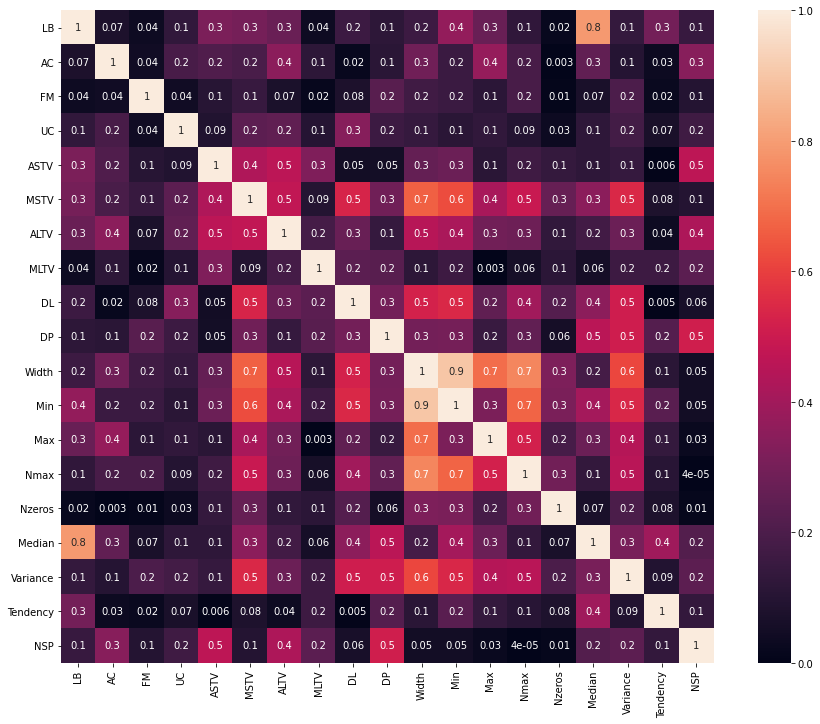

In [11]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(df.corr().abs(), vmin=0, vmax=1, annot=True, fmt='0.1g', square=True, ax=ax)

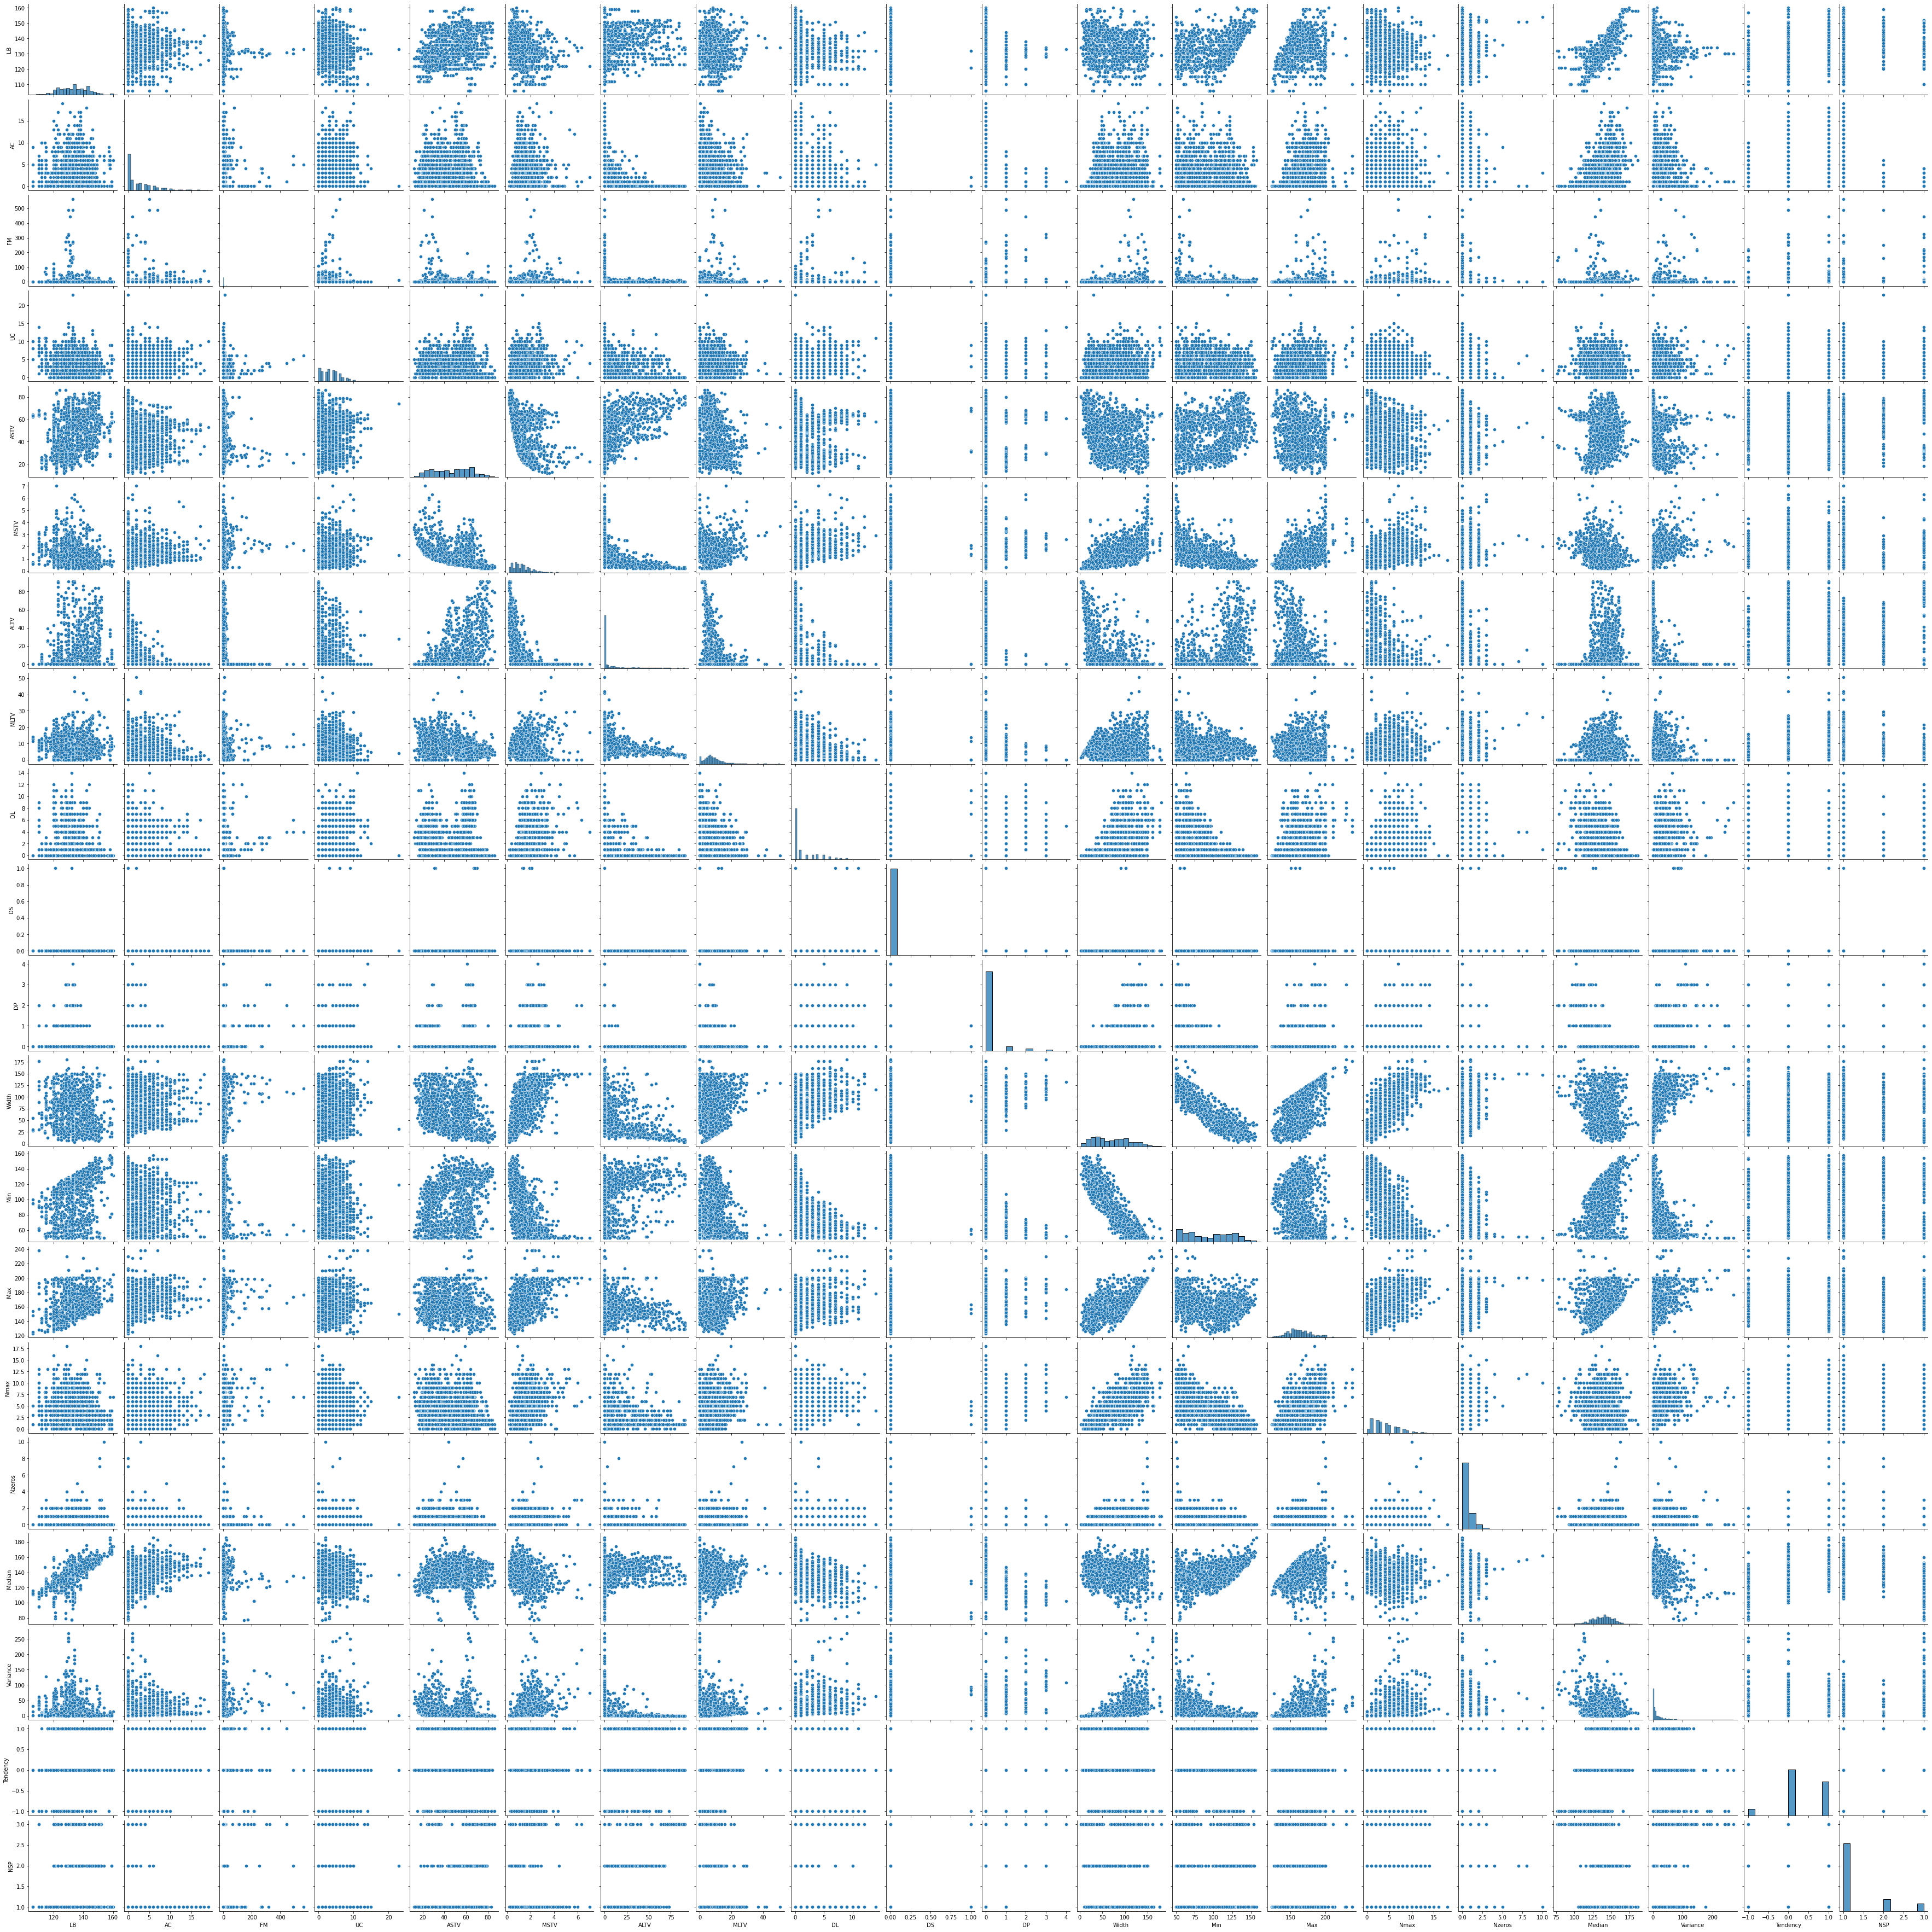

In [20]:
sns.pairplot(df)

# Tests for Statistical Significance

#### Create sub-dataframes corresponding to each of the normal, suspect, and pathological classes of the output ('NSP')

In [12]:
df_NSP_1 = df[df['NSP']==1]
df_NSP_2 = df[df['NSP']==2]
df_NSP_3 = df[df['NSP']==3]

#### Investigate whether there are statistically significant differences between the distributions of the feature 'LB', between the above classes (normal vs suspect and normal vs pathological)

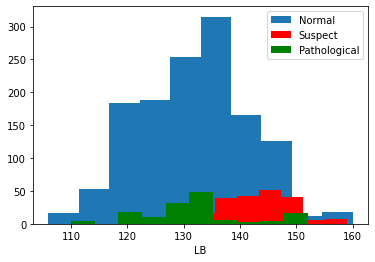

In [72]:
plt.hist(df_NSP_1['LB'], label='Normal')
plt.hist(df_NSP_2['LB'], color='r', label='Suspect')
plt.hist(df_NSP_3['LB'], color='g', label='Pathological')
_ = plt.xlabel('LB')
_ = plt.legend()

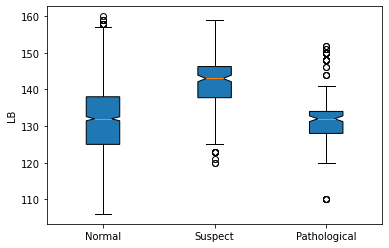

In [121]:
_ = plt.boxplot([df_NSP_1['LB'].values, df_NSP_2['LB'].values, df_NSP_3['LB'].values], notch=True, patch_artist=True, labels=['Normal', 'Suspect', 'Pathological'])
_ = plt.ylabel('LB')

### Two-sample t-tests

#### Compare the distributions of feature 'LB' between the normal and suspect groups

In [122]:
t12, p12 = ttest_ind(df_NSP_1['LB'].values, df_NSP_2['LB'].values, equal_var=False)
print("p-value for comparison of normal and suspect: ", p12)

p-value for comparison of normal and suspect:  1.1441296602235516e-45


#### Compare the distributions of feature 'LB' between the normal and pathological groups

In [123]:
t13, p13 = ttest_ind(df_NSP_1['LB'].values, df_NSP_3['LB'].values, equal_var=False)
print("p-value for comparison of normal and pathological: ", p13)

p-value for comparison of normal and pathological:  0.7924155818685646


### One-way ANOVA test

#### Compare the distributions of feature 'LB' between the normal, suspect, and pathological groups

In [65]:
f, p_anova = f_oneway(df_NSP_1['LB'].values, df_NSP_2['LB'].values, df_NSP_3['LB'].values)
print("p-value for ANOVA: ", p_anova)

p-value for ANOVA:  4.417561951903927e-45


### Performing t-tests and ANOVA tests across features

In [69]:
print(df.columns[:-1])

Index(['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DP',
       'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Median', 'Variance',
       'Tendency'],
      dtype='object')


         p(Normal-Suspect) p(Normal-Pathological)   p-anova
LB                     0.0               0.792416       0.0
AC                     0.0                    0.0       0.0
FM                0.563855               0.015123  0.000077
UC                     0.0               0.008462       0.0
ASTV                   0.0                    0.0       0.0
MSTV                   0.0               0.088193       0.0
ALTV                   0.0                    0.0       0.0
MLTV              0.004513                    0.0       0.0
DL                     0.0               0.000002       0.0
DP                0.288421                    0.0       0.0
Width                  0.0               0.069975       0.0
Min                    0.0               0.004796       0.0
Max                0.06321               0.754275  0.226215
Nmax              0.000235               0.071705  0.000025
Nzeros            0.142233               0.741631  0.185459
Median                 0.0              

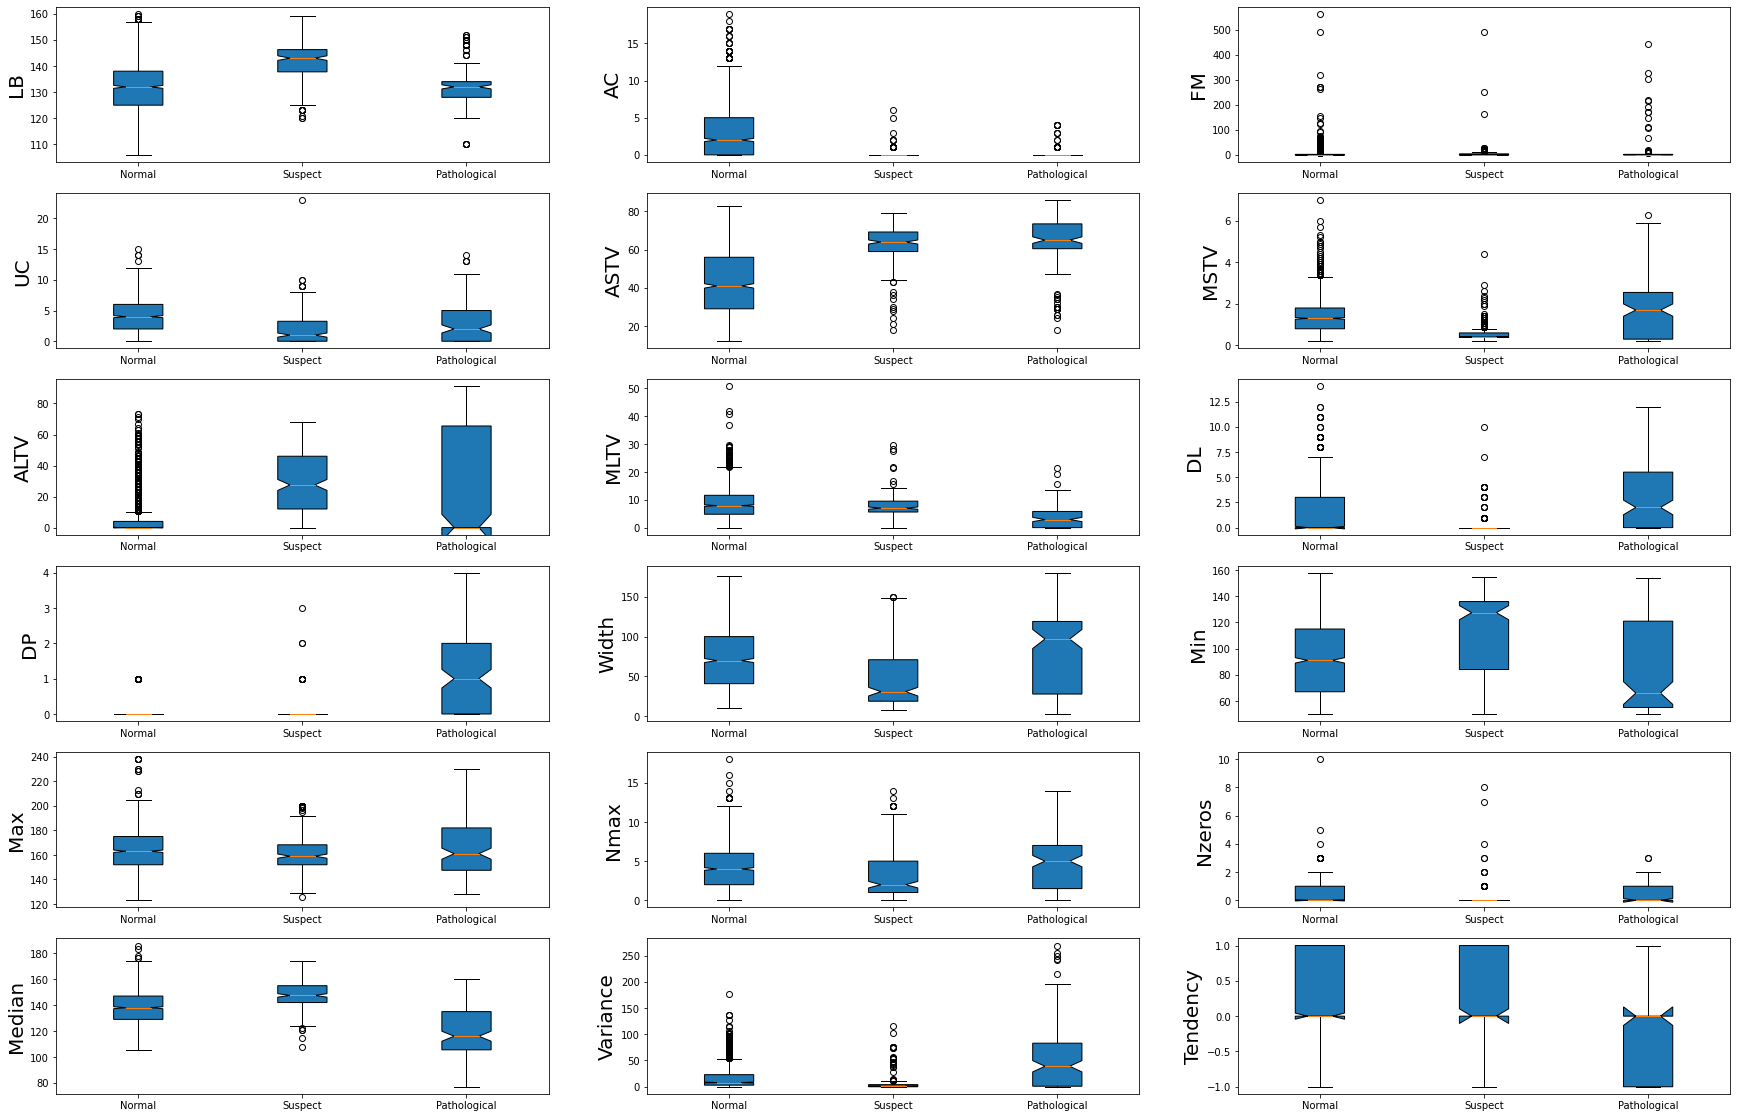

In [124]:
hypothesis_table = pd.DataFrame(columns=['p(Normal-Suspect)', 'p(Normal-Pathological)', 'p-anova'])

fig = plt.figure(figsize=(30,20))
for pos, feature in enumerate(df.columns[:-1]):
    t12, p12 = ttest_ind(df_NSP_1[feature].values, df_NSP_2[feature].values, equal_var=False)
    t13, p13 = ttest_ind(df_NSP_1[feature].values, df_NSP_3[feature].values, equal_var=False)
    f, p_anova = f_oneway(df_NSP_1[feature].values, df_NSP_2[feature].values, df_NSP_3[feature].values)
    
    hypothesis_table.loc[feature, 'p(Normal-Suspect)'] = p12
    hypothesis_table.loc[feature, 'p(Normal-Pathological)'] = p13
    hypothesis_table.loc[feature, 'p-anova'] = p_anova
    
    plt.subplot(6, 3, pos+1)
    _ = plt.boxplot([df_NSP_1[feature].values, df_NSP_2[feature].values, df_NSP_3[feature].values], notch=True, patch_artist=True, labels=['Normal', 'Suspect', 'Pathological'])
    _ = plt.ylabel(feature, fontsize=20)

print(hypothesis_table)


# Regression

### Applying Ridge Regression

[0.8264705882352941, 0.8264705882352941, 0.8264705882352941, 0.8264705882352941, 0.8276470588235293]


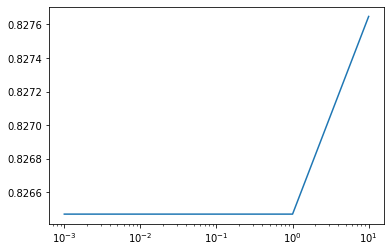

In [11]:
scores = []


def scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    y_pred = np.round(y_pred).astype(int)
    return accuracy_score(y, y_pred)
    


for alpha in [0.001, 0.01, .1, 1, 10]:
    clf_ridge = Ridge(alpha=alpha)
    scores.append(np.mean(cross_val_score(clf_ridge, X_df, y, cv=5, scoring=scorer)))
    
print(scores)
_ = plt.semilogx([0.001, 0.01, .1, 1, 10], scores)

### Applying Random Forest Regressor

In [13]:
clf_rf = RandomForestRegressor(max_depth=8, n_estimators=700)
scores = cross_val_score(clf_rf, X_df, y, cv=5, scoring=scorer)
print(scores)
print(np.mean(scores))

[0.95       0.90294118 0.94117647 0.92352941 0.94117647]
0.931764705882353


### Applying LGBM Regressor

In [15]:
clf_lgbm = LGBMRegressor(boosting_type='gbdt', num_leaves=5, max_depth=8, min_child_samples=20, learning_rate=0.1, n_estimators=700)
scores = cross_val_score(clf_lgbm, X_df, y, cv=5, scoring=scorer)
print(scores)
print(np.mean(scores))

[0.96764706 0.90588235 0.94705882 0.94411765 0.96764706]
0.9464705882352942


# Classification

### Applying Logistic Regression

In [117]:
clf_log_reg = LogisticRegression()
scores = cross_val_score(clf_log_reg, X_df, y, cv=5, scoring='accuracy')
print(scores)
print(np.mean(scores))

[0.92941176 0.9        0.90882353 0.88235294 0.87352941]
0.8988235294117647


### Lasso Classifier

In [118]:
clf_lasso = LogisticRegression(penalty='l1', solver='liblinear')
scores = cross_val_score(clf_lasso, X_df, y, cv=5, scoring='accuracy')
print(scores)
print(np.mean(scores))

[0.92941176 0.9        0.90882353 0.87352941 0.88529412]
0.8994117647058824


### Ridge Classififer

[0.8658823529411765, 0.8658823529411765, 0.8658823529411765, 0.8658823529411765, 0.8652941176470588]


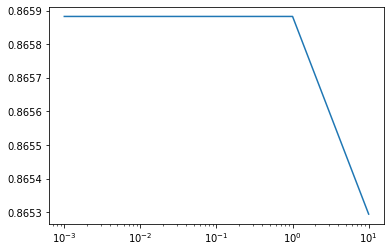

In [10]:
scores = []

for alpha in [0.001, 0.01, .1, 1, 10]:
    clf_ridge = RidgeClassifier(alpha=alpha)
    scores.append(np.mean(cross_val_score(clf_ridge, X_df, y, cv=5, scoring='accuracy')))
    
print(scores)
_ = plt.semilogx([0.001, 0.01, .1, 1, 10], scores)

### Applying LDA

In [67]:
clf_lda = LinearDiscriminantAnalysis()
scores = cross_val_score(clf_lda, X_df, y, cv=5, scoring='accuracy')
print(scores)
print(np.mean(scores))

[0.87352941 0.87058824 0.89705882 0.87647059 0.86176471]
0.8758823529411763


### Applying Random Forest Classifier

In [101]:
class_wts = {0:1, 1:1, 2:1}

clf_rf = RandomForestClassifier(max_depth=8, n_estimators=700, class_weight=class_wts)
scores = cross_val_score(clf_rf, X_df, y, cv=5, scoring='accuracy')
print(scores)
print(np.mean(scores))

[0.94705882 0.92647059 0.94117647 0.92647059 0.95588235]
0.9394117647058824


In [103]:
class_wts = {0:1, 1:1, 2:10}

clf_rf = RandomForestClassifier(max_depth=8, n_estimators=700, class_weight=class_wts)
scores = cross_val_score(clf_rf, X_df, y, cv=5, scoring='accuracy')
print(scores)
print(np.mean(scores))

[0.95294118 0.92352941 0.94117647 0.92352941 0.94411765]
0.9370588235294118


### Applying Boosted Trees

#### LGBM without class weights

In [104]:
class_wts = {0:1, 1:1, 2:1}

clf_lgbm = LGBMClassifier(boosting_type='gbdt', num_leaves=5, max_depth=8, min_child_samples=20, learning_rate=0.1, n_estimators=700, class_weight=class_wts)
scores = cross_val_score(clf_lgbm, X_df, y, cv=5, scoring='accuracy')
print(scores)
print(np.mean(scores))

[0.96764706 0.94117647 0.97647059 0.94705882 0.96470588]
0.9594117647058823


In [105]:
class_wts = {0:1, 1:5, 2:10}

clf_lgbm = LGBMClassifier(boosting_type='gbdt', num_leaves=5, max_depth=8, min_child_samples=20, learning_rate=0.1, n_estimators=700, class_weight=class_wts)
scores = cross_val_score(clf_lgbm, X_df, y, cv=5, scoring='accuracy')
print(scores)
print(np.mean(scores))

[0.95882353 0.93529412 0.97352941 0.94411765 0.96764706]
0.9558823529411764


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, shuffle=True)

0.9735294117647059


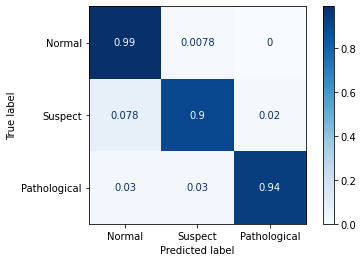

In [109]:
clf_lgbm.fit(X_train, y_train)

y_pred = clf_lgbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
plot_confusion_matrix(clf_lgbm, X_test, y_test, cmap=plt.cm.Blues, normalize='true', display_labels=['Normal', 'Suspect', 'Pathological'])

In [111]:
imp_df_lgbm = pd.DataFrame(clf_lgbm.feature_importances_).T
imp_df_lgbm.columns = X_df.columns
imp_df_lgbm.index = ['Imp']
print(imp_df_lgbm.T.sort_values('Imp', ascending=False))

           Imp
ASTV      1198
ALTV      1127
Median     873
LB         599
Min        589
Variance   526
Width      509
UC         502
MLTV       490
AC         443
FM         361
Max        340
MSTV       251
DP         236
Nmax       230
DL          81
Tendency    24
Nzeros      21


#### XGBoost without class weights

In [113]:
clf_xgb = XGBClassifier(booster='gbtree', max_depth=8, learning_rate=0.1, n_estimators=700, use_label_encoder=False)
scores = cross_val_score(clf_xgb, X_df, y, cv=5, scoring='accuracy')
print(scores)
print(np.mean(scores))

[22:33:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[22:35:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9558823529411765


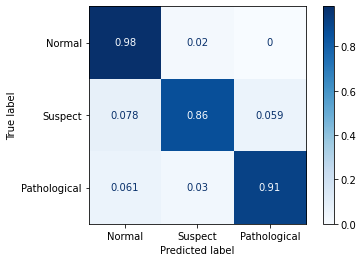

In [116]:
clf_xgb.fit(X_train, y_train)

y_pred = clf_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
_ = plot_confusion_matrix(clf_xgb, X_test, y_test, cmap=plt.cm.Blues, normalize='true',  display_labels=['Normal', 'Suspect', 'Pathological'])

In [115]:
imp_df_xgb = pd.DataFrame(clf_xgb.feature_importances_).T
imp_df_xgb.columns = X_df.columns
imp_df_xgb.index = ['Imp']
print(imp_df_xgb.T.sort_values('Imp', ascending=False))

               Imp
DP        0.199874
MSTV      0.152943
ALTV      0.096084
AC        0.092892
ASTV      0.075534
Median    0.057093
Nmax      0.052225
UC        0.042095
LB        0.037750
Min       0.032764
FM        0.031732
Variance  0.029198
MLTV      0.027506
DL        0.024569
Max       0.021415
Nzeros    0.010706
Width     0.010705
Tendency  0.004915


### Neural Networks

In [16]:
X_train.head()

LB        AC        FM        UC      ASTV      MSTV      ALTV  \
70    0.891798 -0.777409 -0.196295 -0.572687 -0.341274 -0.494215 -0.531412   
1172  1.196493 -0.198143 -0.138993 -0.931275 -0.749103  0.416533 -0.531412   
1433  2.618400 -0.487776 -0.196295  1.937432  0.590907 -0.949589 -0.100785   
349  -0.022285  0.960389  0.176172 -0.572687 -0.516058  1.327282 -0.531412   
678  -0.326979  0.670756 -0.196295  3.730374  0.299600  1.554969 -0.531412   

          MLTV        DL        DP     Width       Min       Max      Nmax  \
70    0.612904 -0.628621 -0.276609 -0.900080  0.987466 -0.332364 -1.377417   
1172  2.473033 -0.628621 -0.276609  1.190235 -1.232626  0.560946  0.635716   
1433  0.156645 -0.628621 -0.276609 -0.772622  1.828410  1.342593 -1.377417   
349   1.964130 -0.628621 -0.276609  1.088268 -1.333539  0.170123 -0.370851   
678  -1.054194  0.605868 -0.276609  0.476469 -0.593509  0.058459  0.300194   

        Nzeros    Median  Variance  Tendency  
70   -0.452970  0.761173 -0.399269  1.125637  
1172  0.962561  0.829969 -0.264354  1.125637  
1433 -0.452970  2.205899 -0.466726 -0.514108  
349  -0.452970  0.210801  0.106662  1.125637  
678  -0.452970 -0.201978  0.039205 -0.514108

In [17]:
def build_model():
    inp = keras.Input(shape=(18,))
    x = layers.Dense(128, activation='relu')(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(3, activation='softmax')(x)
    out = x
    
    model = keras.Model(inputs=[inp], outputs=[out])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
    )
    return model
    

In [18]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1216      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 1,411
Trainable params: 1,411
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train, y_train, batch_size=32, epochs=500, validation_data=(X_test, y_test), verbose=False)

Max Training Accuracy:  0.9426470398902893
Max Validation Accuracy:  0.9264705777168274


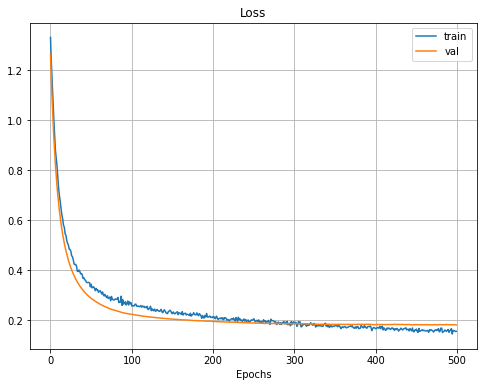

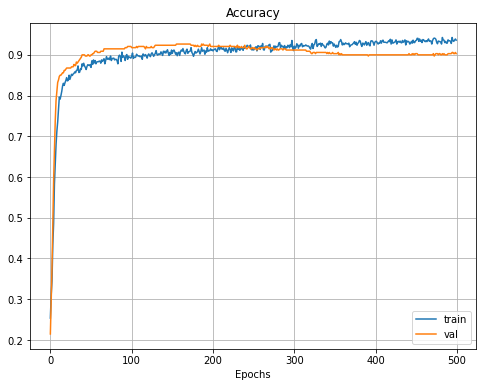

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='val')
ax.set_xlabel('Epochs')
ax.set_title('Loss')
ax.grid(True)
ax.legend()

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(history.history['accuracy'], label='train')
ax.plot(history.history['val_accuracy'], label='val')
ax.set_xlabel('Epochs')
ax.set_title('Accuracy')
ax.grid(True)
_ = ax.legend()

print("Max Training Accuracy: ", np.max(history.history['accuracy']))
print("Max Validation Accuracy: ", np.max(history.history['val_accuracy']))

# Generate a submission file

In [89]:
X_final = pd.read_csv('test.csv')
y_final = pd.read_csv('sample_submission.csv')

In [94]:
X_final.shape

(426, 23)

In [95]:
y_final.shape

(426, 1)

In [96]:
y_final_pred = clf_lgbm.predict(X_final)
y_final['NSP'] = y_final_pred

In [97]:
y_final.to_csv('y_final')